In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
0,1,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               611 non-null    int64  
 1   Glucose                   611 non-null    int64  
 2   BloodPressure             611 non-null    int64  
 3   SkinThickness             611 non-null    int64  
 4   Insulin                   611 non-null    int64  
 5   BMI                       611 non-null    float64
 6   DiabetesPedigreeFunction  611 non-null    float64
 7   Age                       611 non-null    int64  
 8   target                    611 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.1 KB


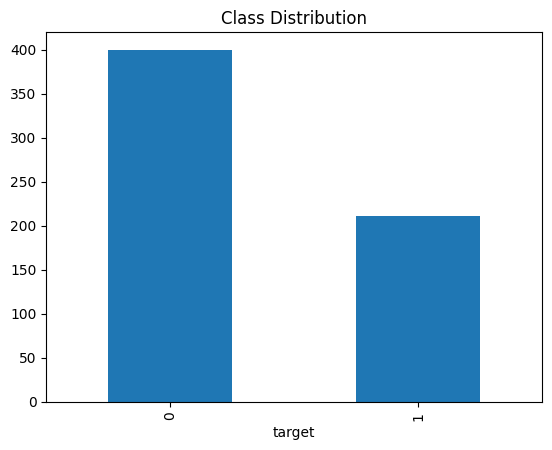

Pregnancies                   0
Glucose                       5
BloodPressure                30
SkinThickness               177
Insulin                     294
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
target                        0
dtype: int64

In [3]:
df.info()
df.describe()
df['target'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Check 0s in features that shouldn't be 0
features_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features_with_zero_invalid] = df[features_with_zero_invalid].replace(0, np.nan)
df.isna().sum()


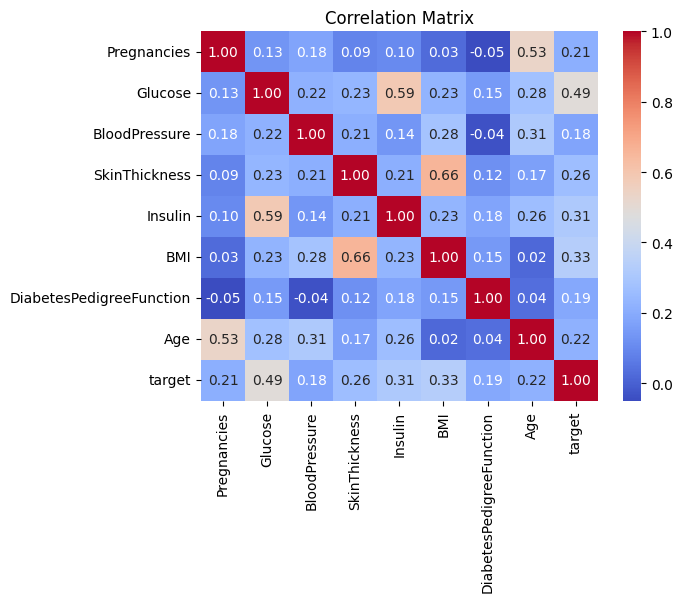

In [4]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Preprocessing

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import optuna
import shap
import warnings
warnings.filterwarnings('ignore')


X = df.drop("target", axis=1)
y = df["target"]

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

2025-05-18 15:36:30.131097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 15:36:30.133892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 15:36:30.140734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747569990.152180  174002 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747569990.155443  174002 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747569990.165304  174002 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Define ANN model:

In [6]:
def create_model(hidden_layer_1=16, hidden_layer_2=8, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_layer_1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(hidden_layer_2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


## Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.4f} +- {scores.std():.4f}")


Epoch 1/50


E0000 00:00:1747569997.171962  174002 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747569997.183061  174002 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4739 - loss: 0.7271   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6613 - loss: 0.6154 
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.7651 - loss: 0.5454
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7508 - loss: 0.5311
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.7736 - loss: 0.4999
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8061 - loss: 0.4699
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7776 - loss: 0.4872
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8157 - loss: 0.4475 
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8172 - loss: 0.4538
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.7916 - loss: 0.4503
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8076 - loss: 0.4431 
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 

## Bayesian Optimization

In [8]:
def objective(trial):
    n1 = trial.suggest_int("hidden_layer_1", 8, 64)
    n2 = trial.suggest_int("hidden_layer_2", 4, 32)
    lr = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
    
    model = KerasClassifier(build_fn=lambda: create_model(n1, n2, lr),
                            epochs=50, batch_size=16, verbose=0)
    
    score = cross_val_score(model, X_scaled, y, cv=3, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)


[I 2025-05-18 15:37:07,785] A new study created in memory with name: no-name-2a41f127-8dc6-4682-a8ea-3b1edfc4d54c
[I 2025-05-18 15:37:14,486] Trial 0 finished with value: 0.7168856048166393 and parameters: {'hidden_layer_1': 62, 'hidden_layer_2': 28, 'learning_rate': 0.0234958550262299}. Best is trial 0 with value: 0.7168856048166393.
[I 2025-05-18 15:37:21,298] Trial 1 finished with value: 0.7725297015357867 and parameters: {'hidden_layer_1': 12, 'hidden_layer_2': 16, 'learning_rate': 0.0003841942426706523}. Best is trial 1 with value: 0.7725297015357867.
[I 2025-05-18 15:37:27,802] Trial 2 finished with value: 0.7447680221513893 and parameters: {'hidden_layer_1': 18, 'hidden_layer_2': 6, 'learning_rate': 0.002959025777977124}. Best is trial 1 with value: 0.7725297015357867.
[I 2025-05-18 15:37:34,266] Trial 3 finished with value: 0.7495894909688013 and parameters: {'hidden_layer_1': 34, 'hidden_layer_2': 8, 'learning_rate': 0.0027554128831241893}. Best is trial 1 with value: 0.772529

Best parameters: {'hidden_layer_1': 12, 'hidden_layer_2': 16, 'learning_rate': 0.0003841942426706523}


## Final Version based on bayesian optimization

In [9]:
best_params = study.best_params
final_model = create_model(best_params['hidden_layer_1'],
                           best_params['hidden_layer_2'],
                           best_params['learning_rate'])

final_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

y_pred = (final_model.predict(X_test) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[[63 18]
 [15 27]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        81
           1       0.60      0.64      0.62        42

    accuracy                           0.73       123
   macro avg       0.70      0.71      0.71       123
weighted avg       0.74      0.73      0.73       123



## Model Interpretability with Permutation Importance

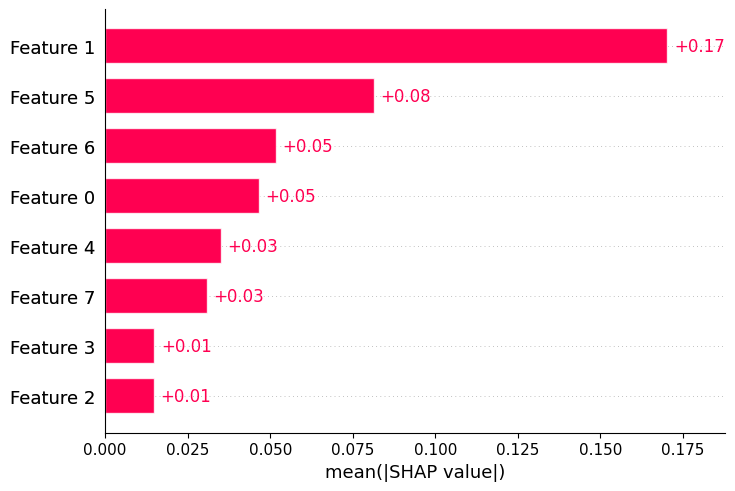

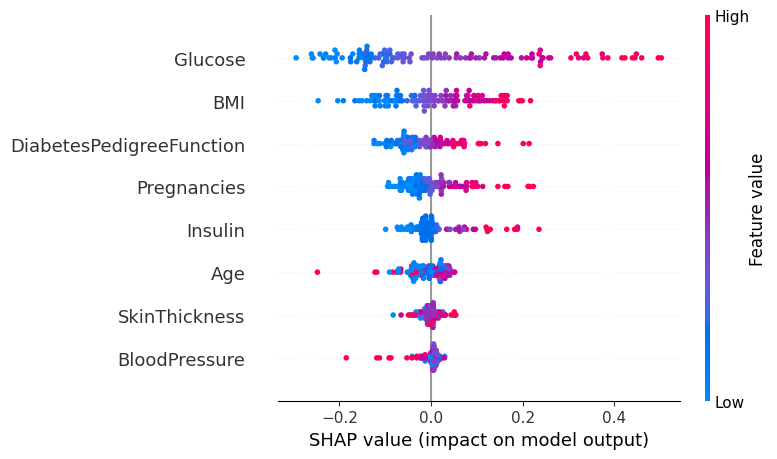

In [12]:
import shap
import matplotlib.pyplot as plt

final_model = create_model(**best_params)
final_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

explainer = shap.Explainer(final_model, X_train)

shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=10)
shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1].tolist())
